# Chapter 2: Markov Decision Processes (MDPs)

This notebook demonstrates the fundamental concepts of MDPs through Python implementations.

## 🚀 Google Colab Ready
**Run the setup cell below first to install all dependencies!**

## Contents:
1. [Setup and Installation](#setup)
2. [MDP Definition and Components](#mdp-definition)
3. [Value Functions](#value-functions)
4. [Bellman Equations](#bellman-equations)
5. [Value Iteration Algorithm](#value-iteration)
6. [Policy Iteration Algorithm](#policy-iteration)
7. [OpenAI Gym Examples](#gym-examples)

---

## Setup and Installation <a id="setup"></a>

**🔧 Google Colab Setup - Run this cell first!**

In [1]:
# 🔧 Google Colab Setup - Run this cell first!
print("🚀 Setting up MDP environment...")

# Install required packages
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scipy --quiet

print("✅ Packages installed successfully!")

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import solve
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting for Colab
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

print("📊 Libraries configured successfully!")
print("🎉 Setup complete! Ready to explore MDPs!")

🚀 Setting up MDP environment...
✅ Packages installed successfully!
📊 Libraries configured successfully!
🎉 Setup complete! Ready to explore MDPs!


## 1. MDP Definition and Components <a id="mdp-definition"></a>

An MDP is defined by the 5-tuple: $(\mathcal{S}, \mathcal{A}, P, R, \gamma)$

Let's implement a simple GridWorld MDP from scratch.

States: 14
Actions: ['up', 'down', 'left', 'right']
Discount factor: 0.9


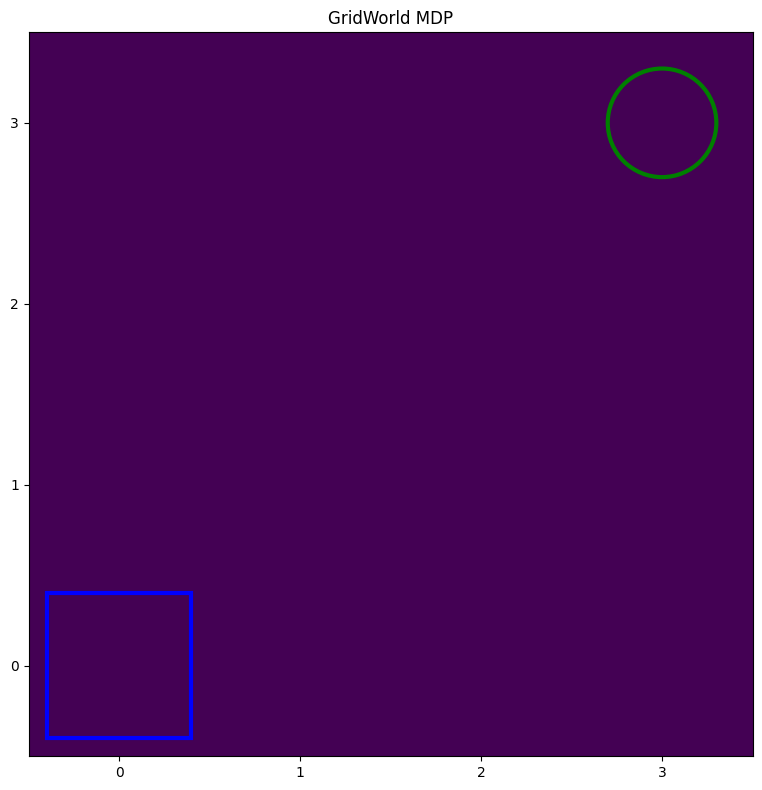

In [2]:
class GridWorldMDP:
    """Simple GridWorld MDP implementation from scratch."""

    def __init__(self, height=4, width=4, start=(0,0), goals=[(3,3)], obstacles=[], gamma=0.9):
        self.height = height
        self.width = width
        self.start = start
        self.goals = goals
        self.obstacles = obstacles
        self.gamma = gamma

        # Define state and action spaces
        self.states = [(i, j) for i in range(height) for j in range(width)
                      if (i, j) not in obstacles]
        self.actions = ['up', 'down', 'left', 'right']

        # State and action indexing
        self.state_to_idx = {s: i for i, s in enumerate(self.states)}
        self.idx_to_state = {i: s for i, s in enumerate(self.states)}
        self.action_to_idx = {a: i for i, a in enumerate(self.actions)}

        self.n_states = len(self.states)
        self.n_actions = len(self.actions)

        # Initialize transition probabilities and rewards
        self._build_transition_probabilities()
        self._build_rewards()

    def _build_transition_probabilities(self):
        """Build transition probability matrix P(s'|s,a)."""
        self.P = np.zeros((self.n_states, self.n_actions, self.n_states))

        for s_idx, state in enumerate(self.states):
            for a_idx, action in enumerate(self.actions):
                next_state = self._get_next_state(state, action)
                next_s_idx = self.state_to_idx[next_state]
                self.P[s_idx, a_idx, next_s_idx] = 1.0

    def _get_next_state(self, state, action):
        """Get next state given current state and action."""
        i, j = state

        if action == 'up':
            next_state = (max(0, i-1), j)
        elif action == 'down':
            next_state = (min(self.height-1, i+1), j)
        elif action == 'left':
            next_state = (i, max(0, j-1))
        elif action == 'right':
            next_state = (i, min(self.width-1, j+1))

        # Check if next state is valid (not an obstacle)
        if next_state in self.obstacles:
            return state  # Stay in current state
        return next_state

    def _build_rewards(self):
        """Build reward function R(s,a)."""
        self.R = np.full((self.n_states, self.n_actions), -0.01)  # Living penalty

        # Goal rewards
        for goal in self.goals:
            if goal in self.state_to_idx:
                goal_idx = self.state_to_idx[goal]
                self.R[goal_idx, :] = 1.0

    def visualize_grid(self, values=None, policy=None):
        """Visualize the gridworld with optional values or policy."""
        fig, ax = plt.subplots(figsize=(8, 8))

        # Create grid
        grid = np.zeros((self.height, self.width))

        if values is not None:
            for state, value in zip(self.states, values):
                i, j = state
                grid[i, j] = value

        # Plot heatmap
        im = ax.imshow(grid, cmap='viridis', aspect='equal')

        # Add text annotations
        for state in self.states:
            i, j = state
            s_idx = self.state_to_idx[state]

            # Value annotation
            if values is not None:
                ax.text(j, i, f'{values[s_idx]:.2f}',
                       ha='center', va='center', fontsize=10, color='white')

            # Policy arrows
            if policy is not None:
                action_idx = policy[s_idx]
                action = self.actions[action_idx]
                arrow_props = {'up': (0, -0.3), 'down': (0, 0.3),
                             'left': (-0.3, 0), 'right': (0.3, 0)}
                dx, dy = arrow_props[action]
                ax.arrow(j, i, dx, dy, head_width=0.1, head_length=0.1,
                        fc='red', ec='red')

        # Mark special states
        start_i, start_j = self.start
        ax.add_patch(plt.Rectangle((start_j-0.4, start_i-0.4), 0.8, 0.8,
                                  fill=False, edgecolor='blue', linewidth=3))

        for goal in self.goals:
            goal_i, goal_j = goal
            ax.add_patch(plt.Circle((goal_j, goal_i), 0.3,
                                  fill=False, edgecolor='green', linewidth=3))

        # Set labels and title
        ax.set_xlim(-0.5, self.width-0.5)
        ax.set_ylim(-0.5, self.height-0.5)
        ax.set_xticks(range(self.width))
        ax.set_yticks(range(self.height))
        ax.set_title('GridWorld MDP')

        if values is not None:
            plt.colorbar(im, ax=ax, label='State Value')

        plt.tight_layout()
        plt.show()

# Create and visualize a simple gridworld
mdp = GridWorldMDP(height=4, width=4, goals=[(3,3)], obstacles=[(1,1), (2,2)])
print(f"States: {len(mdp.states)}")
print(f"Actions: {mdp.actions}")
print(f"Discount factor: {mdp.gamma}")
mdp.visualize_grid()

## 2. Value Functions <a id="value-functions"></a>

From the textbook:
- State value function: $V^\pi(s) = \mathbb{E}^\pi[\sum_{t=0}^\infty \gamma^t R_t | S_0 = s]$
- Action value function: $Q^\pi(s,a) = \mathbb{E}^\pi[\sum_{t=0}^\infty \gamma^t R_t | S_0 = s, A_0 = a]$

Policy evaluation converged in 106 iterations

Random Policy State Values:
V((0, 0)) = 0.0377
V((0, 1)) = 0.0683
V((0, 2)) = 0.1736
V((0, 3)) = 0.2871
V((1, 0)) = 0.0683
V((1, 2)) = 0.2871
V((1, 3)) = 0.5727
V((2, 0)) = 0.1736
V((2, 1)) = 0.2871
V((2, 3)) = 1.4428
V((3, 0)) = 0.2871
V((3, 1)) = 0.5727
V((3, 2)) = 1.4428
V((3, 3)) = 2.9987


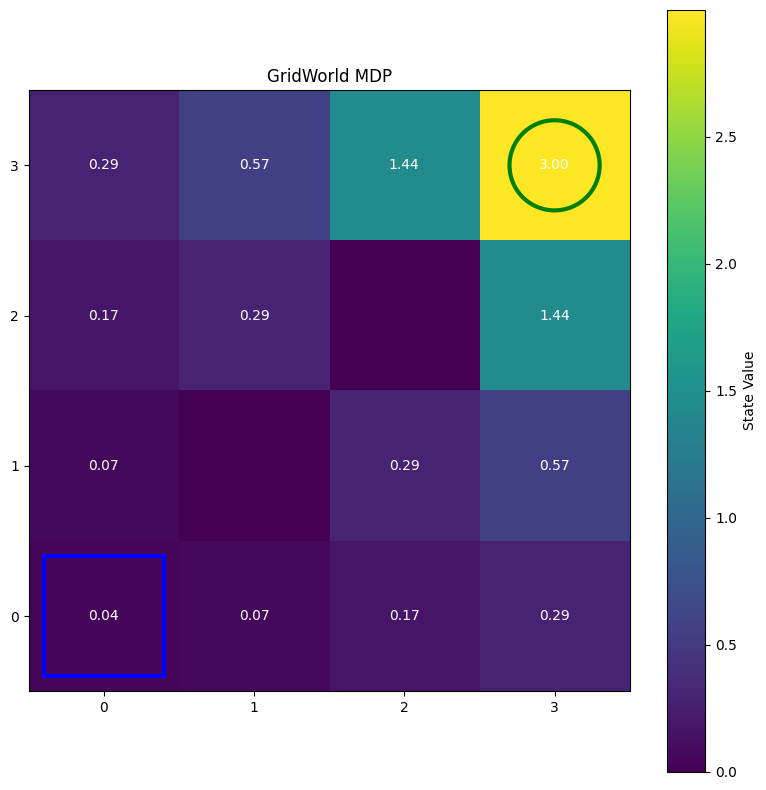

In [3]:
def policy_evaluation(mdp, policy, theta=1e-6, max_iterations=1000):
    """Evaluate a policy using iterative policy evaluation.

    Args:
        mdp: GridWorldMDP instance
        policy: Policy matrix of shape (n_states, n_actions)
        theta: Convergence threshold
        max_iterations: Maximum number of iterations

    Returns:
        V: State value function
    """
    V = np.zeros(mdp.n_states)

    for iteration in range(max_iterations):
        delta = 0
        V_new = np.zeros(mdp.n_states)

        for s in range(mdp.n_states):
            # Bellman equation for policy evaluation
            v = 0
            for a in range(mdp.n_actions):
                # V^π(s) = Σ_a π(a|s) Σ_s' P(s'|s,a)[R(s,a) + γV^π(s')]
                action_value = 0
                for s_next in range(mdp.n_states):
                    action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
                v += policy[s, a] * action_value

            V_new[s] = v
            delta = max(delta, abs(V[s] - V_new[s]))

        V = V_new.copy()

        if delta < theta:
            print(f"Policy evaluation converged in {iteration+1} iterations")
            break

    return V

def compute_q_values(mdp, V):
    """Compute Q-values from state values.

    Q^π(s,a) = Σ_s' P(s'|s,a)[R(s,a) + γV^π(s')]
    """
    Q = np.zeros((mdp.n_states, mdp.n_actions))

    for s in range(mdp.n_states):
        for a in range(mdp.n_actions):
            for s_next in range(mdp.n_states):
                Q[s, a] += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])

    return Q

# Example: Random policy evaluation
random_policy = np.ones((mdp.n_states, mdp.n_actions)) / mdp.n_actions
V_random = policy_evaluation(mdp, random_policy)
Q_random = compute_q_values(mdp, V_random)

print("\nRandom Policy State Values:")
for i, state in enumerate(mdp.states):
    print(f"V({state}) = {V_random[i]:.4f}")

mdp.visualize_grid(values=V_random)

## 3. Value Iteration Algorithm <a id="value-iteration"></a>

Value iteration implements the Bellman optimality equation:
$V^*(s) = \max_a \sum_{s'} P(s'|s,a)[R(s,a) + \gamma V^*(s')]$

Value iteration converged in 133 iterations

Optimal Policy:
π*((0, 0)) = down, V*((0, 0)) = 5.2675
π*((0, 1)) = right, V*((0, 1)) = 5.8639
π*((0, 2)) = down, V*((0, 2)) = 6.5266
π*((0, 3)) = down, V*((0, 3)) = 7.2629
π*((1, 0)) = down, V*((1, 0)) = 5.8639
π*((1, 2)) = right, V*((1, 2)) = 7.2629
π*((1, 3)) = down, V*((1, 3)) = 8.0810
π*((2, 0)) = down, V*((2, 0)) = 6.5266
π*((2, 1)) = down, V*((2, 1)) = 7.2629
π*((2, 3)) = down, V*((2, 3)) = 8.9900
π*((3, 0)) = right, V*((3, 0)) = 7.2629
π*((3, 1)) = right, V*((3, 1)) = 8.0810
π*((3, 2)) = right, V*((3, 2)) = 8.9900
π*((3, 3)) = down, V*((3, 3)) = 10.0000


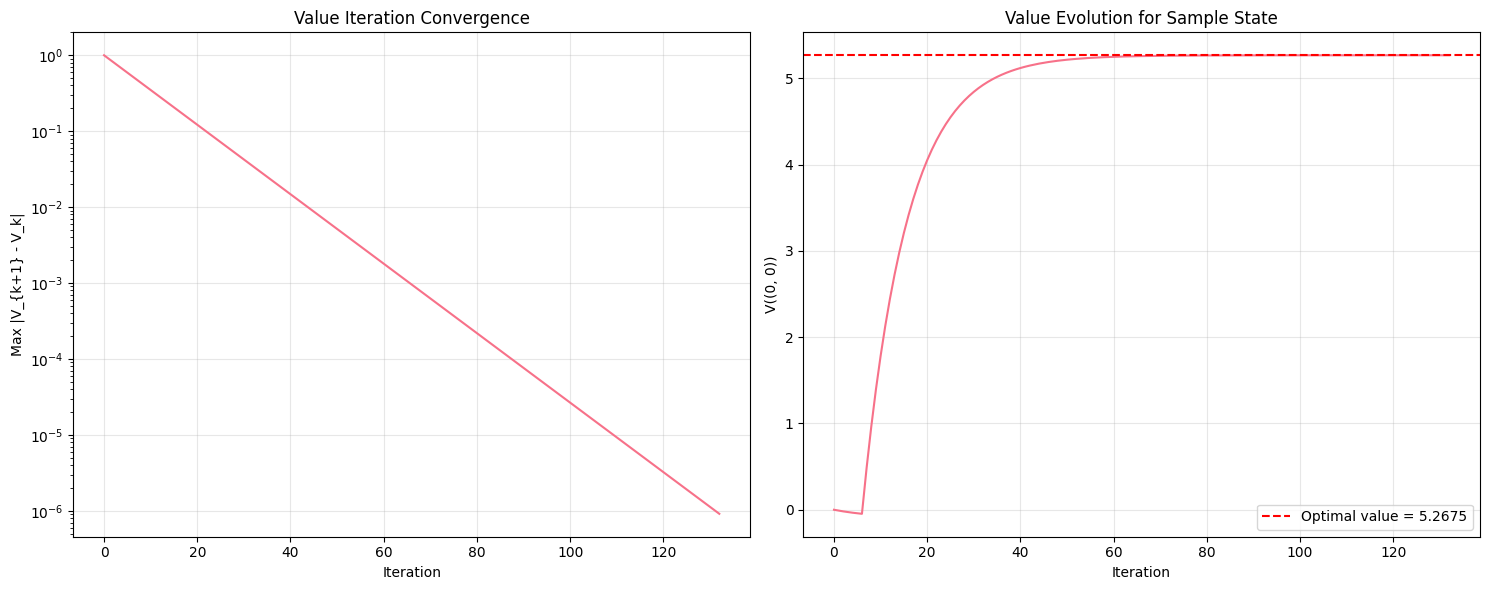

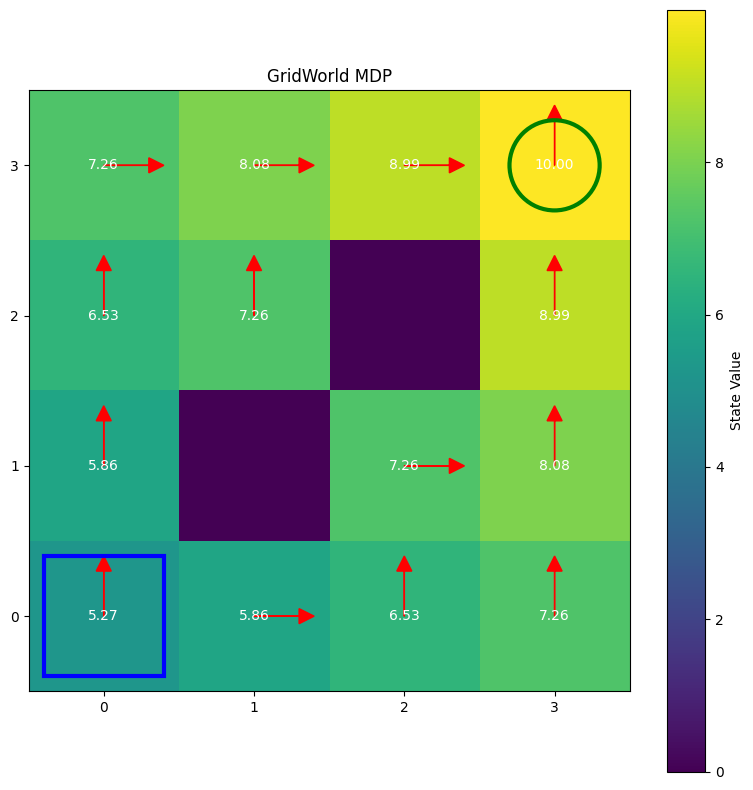

In [4]:
def value_iteration(mdp, theta=1e-6, max_iterations=1000):
    """Value iteration algorithm.

    Returns:
        V: Optimal state value function
        policy: Optimal policy
        convergence_data: Data for plotting convergence
    """
    V = np.zeros(mdp.n_states)
    convergence_data = {'iterations': [], 'max_delta': [], 'values': []}

    for iteration in range(max_iterations):
        delta = 0
        V_new = np.zeros(mdp.n_states)

        for s in range(mdp.n_states):
            # Bellman optimality equation
            action_values = []
            for a in range(mdp.n_actions):
                action_value = 0
                for s_next in range(mdp.n_states):
                    action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
                action_values.append(action_value)

            V_new[s] = max(action_values)
            delta = max(delta, abs(V[s] - V_new[s]))

        # Store convergence data
        convergence_data['iterations'].append(iteration)
        convergence_data['max_delta'].append(delta)
        convergence_data['values'].append(V.copy())

        V = V_new.copy()

        if delta < theta:
            print(f"Value iteration converged in {iteration+1} iterations")
            break

    # Extract optimal policy
    policy = np.zeros(mdp.n_states, dtype=int)
    for s in range(mdp.n_states):
        action_values = []
        for a in range(mdp.n_actions):
            action_value = 0
            for s_next in range(mdp.n_states):
                action_value += mdp.P[s, a, s_next] * (mdp.R[s, a] + mdp.gamma * V[s_next])
            action_values.append(action_value)
        policy[s] = np.argmax(action_values)

    return V, policy, convergence_data

# Run value iteration
V_optimal, policy_optimal, conv_data = value_iteration(mdp)

print("\nOptimal Policy:")
for i, state in enumerate(mdp.states):
    action = mdp.actions[policy_optimal[i]]
    print(f"π*({state}) = {action}, V*({state}) = {V_optimal[i]:.4f}")

# Visualize results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot convergence
ax1.semilogy(conv_data['iterations'], conv_data['max_delta'])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Max |V_{k+1} - V_k|')
ax1.set_title('Value Iteration Convergence')
ax1.grid(True, alpha=0.3)

# Plot value evolution for a sample state
state_idx = 0  # First state
values_evolution = [v[state_idx] for v in conv_data['values']]
ax2.plot(conv_data['iterations'], values_evolution)
ax2.axhline(V_optimal[state_idx], color='red', linestyle='--',
           label=f'Optimal value = {V_optimal[state_idx]:.4f}')
ax2.set_xlabel('Iteration')
ax2.set_ylabel(f'V({mdp.states[state_idx]})')
ax2.set_title('Value Evolution for Sample State')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize optimal policy
mdp.visualize_grid(values=V_optimal, policy=policy_optimal)